# Agent Training and Experimentation

This notebook provides a comprehensive training and experimentation environment for RL agents on portfolio optimization.

## Objectives
1. Train different RL agents (PPO, DQN) on portfolio environments
2. Compare agent performance across different configurations
3. Analyze training dynamics and convergence
4. Evaluate agents against benchmark strategies
5. Visualize results and performance metrics


## 1. Setup and Imports


In [9]:
# Fix OpenMP error (prevents libiomp5md.dll conflicts)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Import necessary libraries
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append(str(Path('..') / 'src'))

# Import our modules
from data.data_loader import load_and_prepare_data
from environment.portfolio_env import create_portfolio_env
from agents.ppo_agent import PPOAgent
from agents.dqn_agent import DQNAgent

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")


Libraries imported successfully!
Working directory: d:\Engineering\Capstone Project\Capstone_Portfolio_RL\notebooks


## 2. Load and Prepare Data


In [10]:
# Load data with different stock selections
print("Loading data...")

# Simple selection for quick experiments
prices_simple, returns_simple, quality_simple = load_and_prepare_data(
    '../Files', stock_selection='simple'
)

# Diversified selection for comprehensive experiments
prices_diversified, returns_diversified, quality_diversified = load_and_prepare_data(
    '../Files', stock_selection='diversified'
)

print(f"Simple dataset: {prices_simple.shape[0]} days, {prices_simple.shape[1]} stocks")
print(f"Diversified dataset: {prices_diversified.shape[0]} days, {prices_diversified.shape[1]} stocks")

# Display data quality
print("\nData Quality Summary:")
print(f"Simple - Quality Score: {quality_simple['data_quality_score']:.3f}")
print(f"Diversified - Quality Score: {quality_diversified['data_quality_score']:.3f}")


Loading data...
Loading data with simple stock selection...
Selected stocks: ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'JNJ', 'SP500']
✓ Loaded AAPL: 2517 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
✓ Loaded AMZN: 2524 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
✓ Loaded GOOG: 2524 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
✓ Loaded JNJ: 2525 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
✓ Loaded MSFT: 2524 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
✓ Loaded SP500: 2517 rows, columns: ['open', 'high', 'low', 'close', 'adj_close', 'volume']
⚠ Warning: AMZN has 6 duplicate dates. Removing duplicates...
⚠ Warning: GOOG has 6 duplicate dates. Removing duplicates...
⚠ Warning: JNJ has 7 duplicate dates. Removing duplicates...
⚠ Warning: MSFT has 6 duplicate dates. Removing duplicates...

Data Summary:
  Stocks: 6
  Days: 2518
  Date range: 2010-10-01 00:00:00 to 2020

## 3. Create Environments


In [11]:
# Create different environment configurations
print("Creating environments...")

# Simple environment for quick experiments
env_simple = create_portfolio_env(
    env_type='enhanced',
    prices_df=prices_simple,
    returns_df=returns_simple,
    episode_length=252,  # 1 trading year
    lookback_window=20,
    transaction_cost=0.001
)

# Diversified environment for comprehensive experiments
env_diversified = create_portfolio_env(
    env_type='expanded',
    prices_df=prices_diversified,
    returns_df=returns_diversified,
    episode_length=252,
    lookback_window=20,
    transaction_cost=0.001
)

print(f"Simple Environment: {env_simple.__class__.__name__}")
print(f"  State space: {env_simple.observation_space.shape}")
print(f"  Action space: {env_simple.action_space.shape}")

print(f"\nDiversified Environment: {env_diversified.__class__.__name__}")
print(f"  State space: {env_diversified.observation_space.shape}")
print(f"  Action space: {env_diversified.action_space.shape}")


Creating environments...
Expanded environment initialized with 13 stocks
State dimension: 185
Simple Environment: EnhancedPortfolioEnv
  State space: (66,)
  Action space: (6,)

Diversified Environment: ExpandedEnhancedPortfolioEnv
  State space: (185,)
  Action space: (13,)


## 4. Agent Training Functions


In [12]:
def train_agent(env, agent, n_episodes=1000, save_freq=100, verbose=True):
    """
    Train an RL agent on the portfolio environment.
    
    Args:
        env: Portfolio environment
        agent: RL agent to train
        n_episodes: Number of training episodes
        save_freq: Frequency of progress updates
        verbose: Whether to print progress
    
    Returns:
        Dictionary of training metrics
    """
    print(f"Training {agent.__class__.__name__} for {n_episodes} episodes...")
    
    episode_rewards = []
    episode_lengths = []
    losses = []
    
    for episode in range(n_episodes):
        state, info = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False
        
        while not done:
            # Select action
            action = agent.select_action(state, training=True)
            
            # Take step
            next_state, reward, done, truncated, info = env.step(action)
            
            # Store experience (for agents that need it)
            if hasattr(agent, 'store_reward'):
                agent.store_reward(reward, done or truncated)
            elif hasattr(agent, 'store_experience'):
                agent.store_experience(state, action, reward, next_state, done or truncated)
            
            # Update agent
            if episode_length % 10 == 0:  # Update every 10 steps
                update_metrics = agent.update()
                if update_metrics:
                    losses.append(update_metrics.get('loss', 0))
            
            state = next_state
            episode_reward += reward
            episode_length += 1
            
            if truncated:
                break
        
        # Store episode metrics
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        
        # Print progress
        if verbose and episode % save_freq == 0:
            avg_reward = np.mean(episode_rewards[-50:]) if len(episode_rewards) >= 50 else np.mean(episode_rewards)
            avg_length = np.mean(episode_lengths[-50:]) if len(episode_lengths) >= 50 else np.mean(episode_lengths)
            print(f"Episode {episode:4d} | Avg Reward: {avg_reward:8.4f} | Avg Length: {avg_length:6.1f}")
    
    return {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'losses': losses,
        'n_episodes': n_episodes,
        'agent_type': agent.__class__.__name__,
        'env_type': env.__class__.__name__
    }

def evaluate_agent(env, agent, n_episodes=100):
    """
    Evaluate a trained agent on the environment.
    
    Args:
        env: Portfolio environment
        agent: Trained RL agent
        n_episodes: Number of evaluation episodes
    
    Returns:
        Dictionary of evaluation metrics
    """
    print(f"Evaluating {agent.__class__.__name__} for {n_episodes} episodes...")
    
    episode_rewards = []
    episode_returns = []
    episode_lengths = []
    
    for episode in range(n_episodes):
        state, info = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False
        
        while not done:
            # Select action (no training)
            action = agent.select_action(state, training=False)
            
            # Take step
            next_state, reward, done, truncated, info = env.step(action)
            
            state = next_state
            episode_reward += reward
            episode_length += 1
            
            if truncated:
                break
        
        episode_rewards.append(episode_reward)
        episode_returns.append(info['total_return'])
        episode_lengths.append(episode_length)
    
    # Calculate metrics
    metrics = {
        'mean_reward': np.mean(episode_rewards),
        'std_reward': np.std(episode_rewards),
        'mean_return': np.mean(episode_returns),
        'std_return': np.std(episode_returns),
        'mean_length': np.mean(episode_lengths),
        'std_length': np.std(episode_lengths),
        'n_episodes': n_episodes
    }
    
    print(f"Evaluation Results:")
    print(f"  Mean Reward: {metrics['mean_reward']:.4f} ± {metrics['std_reward']:.4f}")
    print(f"  Mean Return: {metrics['mean_return']:.4f} ± {metrics['std_return']:.4f}")
    print(f"  Mean Length: {metrics['mean_length']:.1f} ± {metrics['std_length']:.1f}")
    
    return metrics

print("Training functions defined successfully!")


Training functions defined successfully!


## 5. Quick Training Experiments


In [13]:
# Quick training experiment with PPO on simple environment
print("=== Quick PPO Training Experiment ===")

# Create PPO agent
ppo_agent = PPOAgent(
    state_dim=env_simple.observation_space.shape[0],
    action_dim=env_simple.action_space.shape[0],
    learning_rate=3e-4,
    gamma=0.99,
    clip_ratio=0.2,
    ppo_epochs=4,
    batch_size=64
)

# Train for a short period
ppo_metrics = train_agent(env_simple, ppo_agent, n_episodes=200, save_freq=50)

print(f"\nTraining completed!")
print(f"Final average reward: {np.mean(ppo_metrics['episode_rewards'][-50:]):.4f}")


=== Quick PPO Training Experiment ===
Agent initialized on device: cpu
Training PPOAgent for 200 episodes...
Episode    0 | Avg Reward:   0.5550 | Avg Length:  232.0
Episode   50 | Avg Reward:   0.4238 | Avg Length:  232.0
Episode  100 | Avg Reward:   0.4517 | Avg Length:  232.0
Episode  150 | Avg Reward:   0.4116 | Avg Length:  232.0

Training completed!
Final average reward: 0.2961


## 6. Training Visualization


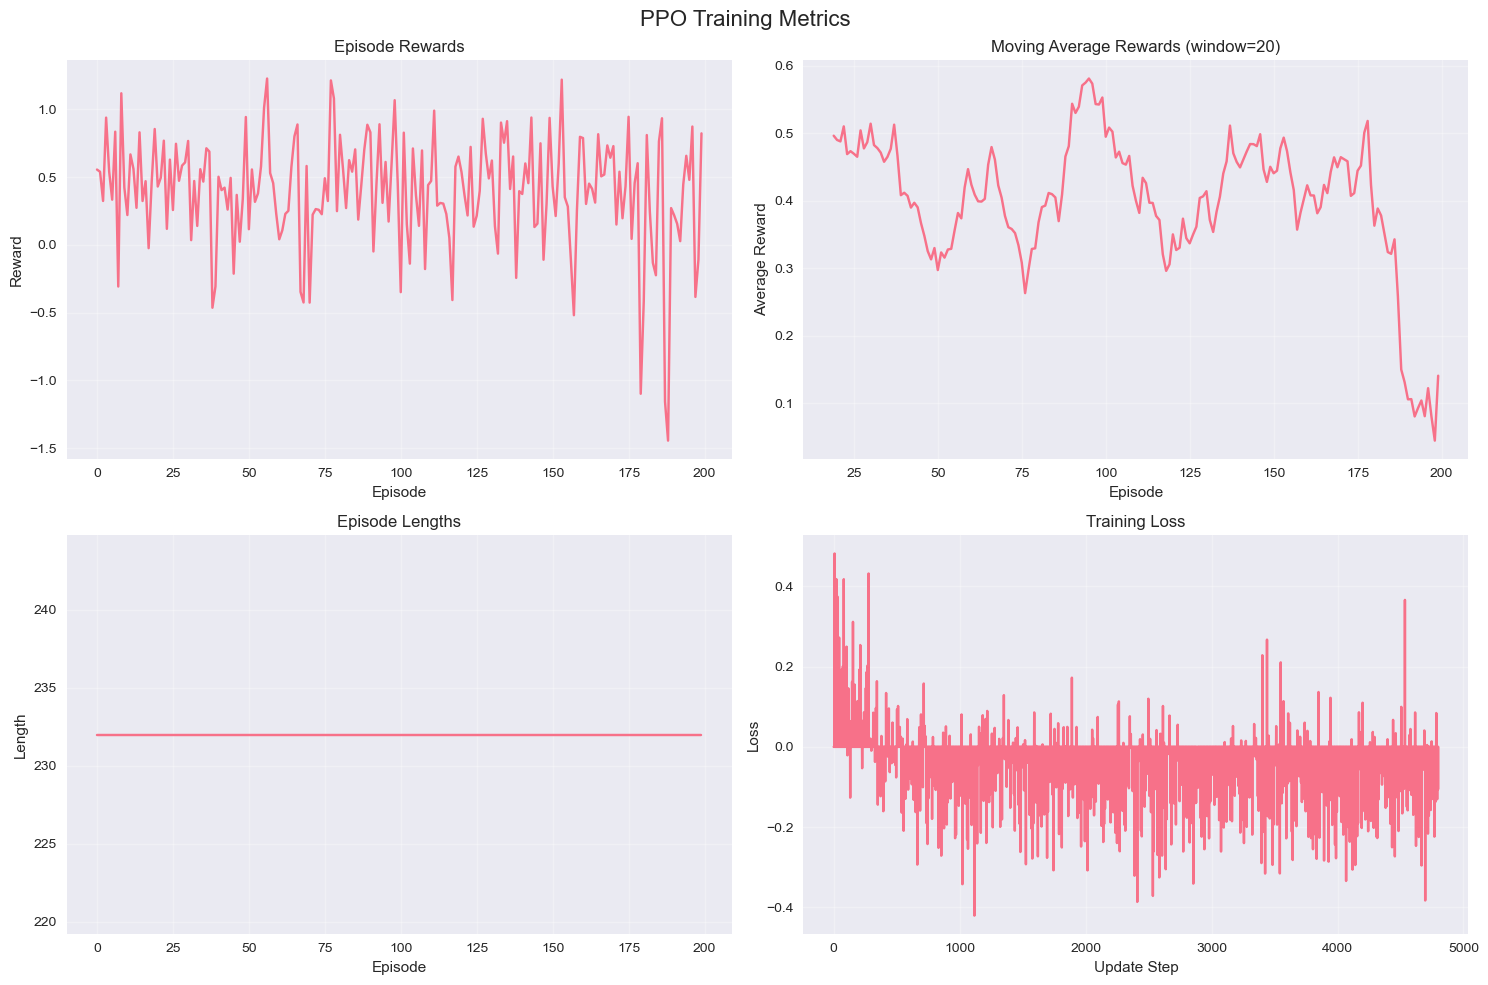

In [14]:
# Plot training metrics
def plot_training_metrics(metrics, title="Training Metrics"):
    """Plot training metrics."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    # Episode rewards
    axes[0, 0].plot(metrics['episode_rewards'])
    axes[0, 0].set_title('Episode Rewards')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Reward')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Moving average of rewards
    window = min(20, len(metrics['episode_rewards']) // 10)
    if window > 1:
        moving_avg = pd.Series(metrics['episode_rewards']).rolling(window=window).mean()
        axes[0, 1].plot(moving_avg)
        axes[0, 1].set_title(f'Moving Average Rewards (window={window})')
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Average Reward')
        axes[0, 1].grid(True, alpha=0.3)
    
    # Episode lengths
    axes[1, 0].plot(metrics['episode_lengths'])
    axes[1, 0].set_title('Episode Lengths')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Length')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Losses (if available)
    if metrics['losses']:
        axes[1, 1].plot(metrics['losses'])
        axes[1, 1].set_title('Training Loss')
        axes[1, 1].set_xlabel('Update Step')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No loss data available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Training Loss')
    
    plt.tight_layout()
    plt.show()

# Plot PPO training metrics
plot_training_metrics(ppo_metrics, "PPO Training Metrics")


## 7. Agent Comparison


In [15]:
# Compare PPO vs DQN on simple environment
print("=== Agent Comparison ===")

# Create DQN agent
dqn_agent = DQNAgent(
    state_dim=env_simple.observation_space.shape[0],
    action_dim=5,  # 5 discrete strategies
    learning_rate=1e-4,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995
)

# Train DQN agent
dqn_metrics = train_agent(env_simple, dqn_agent, n_episodes=200, save_freq=50)

print(f"\nDQN Training completed!")
print(f"Final average reward: {np.mean(dqn_metrics['episode_rewards'][-50:]):.4f}")


=== Agent Comparison ===
Agent initialized on device: cpu
Training DQNAgent for 200 episodes...
Episode    0 | Avg Reward:   1.1298 | Avg Length:  232.0
Episode   50 | Avg Reward:   1.1402 | Avg Length:  232.0
Episode  100 | Avg Reward:   1.1683 | Avg Length:  232.0
Episode  150 | Avg Reward:   1.1611 | Avg Length:  232.0

DQN Training completed!
Final average reward: 1.1701


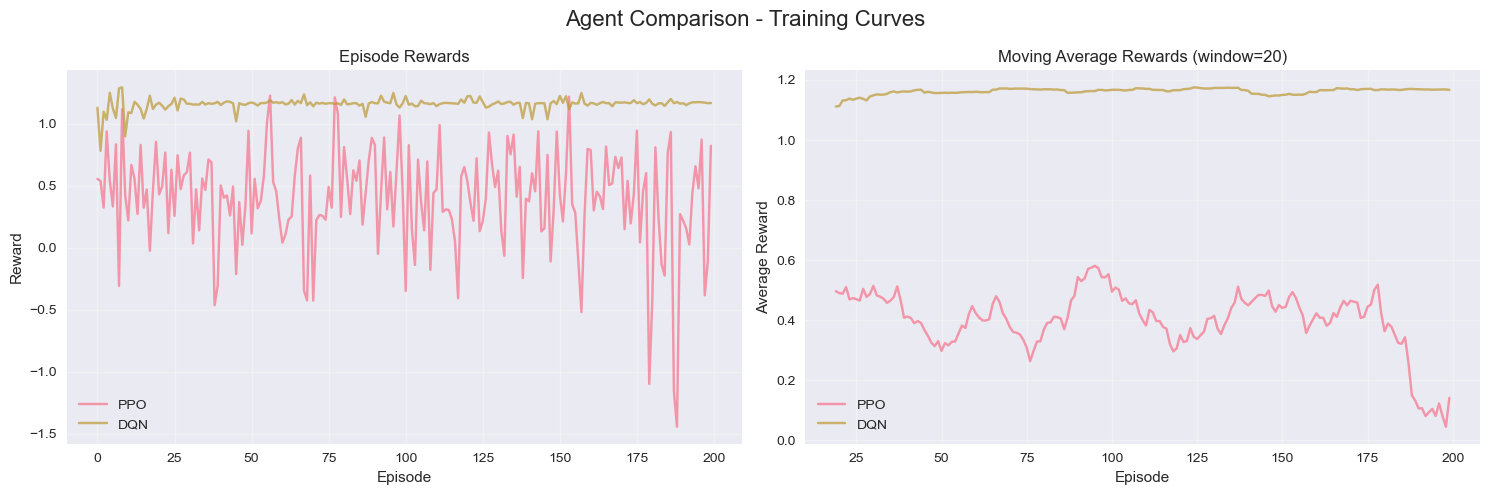


=== Training Summary ===
PPO - Final 50 episodes avg: 0.2961
DQN - Final 50 episodes avg: 1.1701
PPO - Max reward: 1.2267
DQN - Max reward: 1.2934


In [16]:
# Compare training curves
try:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Agent Comparison - Training Curves', fontsize=16)

    # Check if both agents are trained
    if 'ppo_metrics' in globals() and 'dqn_metrics' in globals():
        # Rewards comparison
        axes[0].plot(ppo_metrics['episode_rewards'], label='PPO', alpha=0.7)
        axes[0].plot(dqn_metrics['episode_rewards'], label='DQN', alpha=0.7)
        axes[0].set_title('Episode Rewards')
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Reward')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Moving average comparison
        window = min(20, len(ppo_metrics['episode_rewards']) // 10)
        if window > 1:
            ppo_ma = pd.Series(ppo_metrics['episode_rewards']).rolling(window=window).mean()
            dqn_ma = pd.Series(dqn_metrics['episode_rewards']).rolling(window=window).mean()

            axes[1].plot(ppo_ma, label='PPO', alpha=0.7)
            axes[1].plot(dqn_ma, label='DQN', alpha=0.7)
            axes[1].set_title(f'Moving Average Rewards (window={window})')
            axes[1].set_xlabel('Episode')
            axes[1].set_ylabel('Average Reward')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
        else:
            axes[1].text(0.5, 0.5, 'Need more episodes for moving average', 
                        ha='center', va='center', transform=axes[1].transAxes)
            axes[1].set_title('Moving Average Rewards')
    else:
        axes[0].text(0.5, 0.5, 'Train both PPO and DQN agents first', 
                    ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('Episode Rewards')
        axes[1].text(0.5, 0.5, 'Train both PPO and DQN agents first', 
                    ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Moving Average Rewards')

    plt.tight_layout()
    plt.show()

    # Print comparison summary
    if 'ppo_metrics' in globals() and 'dqn_metrics' in globals():
        print("\n=== Training Summary ===")
        print(f"PPO - Final 50 episodes avg: {np.mean(ppo_metrics['episode_rewards'][-50:]):.4f}")
        print(f"DQN - Final 50 episodes avg: {np.mean(dqn_metrics['episode_rewards'][-50:]):.4f}")
        print(f"PPO - Max reward: {np.max(ppo_metrics['episode_rewards']):.4f}")
        print(f"DQN - Max reward: {np.max(dqn_metrics['episode_rewards']):.4f}")
    else:
        print("Please train both PPO and DQN agents first")
except Exception as e:
    print(f"Error creating comparison plots: {e}")
    print("Make sure both agents have been trained first.")


## 8. Evaluation and Testing


In [17]:
# Evaluate both agents
print("=== Agent Evaluation ===")

# Evaluate PPO
ppo_eval = evaluate_agent(env_simple, ppo_agent, n_episodes=50)

print("\n" + "="*50)

# Evaluate DQN
dqn_eval = evaluate_agent(env_simple, dqn_agent, n_episodes=50)

# Compare evaluation results
print("\n=== Evaluation Comparison ===")
print(f"{'Metric':<20} {'PPO':<15} {'DQN':<15}")
print("-" * 50)
print(f"{'Mean Reward':<20} {ppo_eval['mean_reward']:<15.4f} {dqn_eval['mean_reward']:<15.4f}")
print(f"{'Mean Return':<20} {ppo_eval['mean_return']:<15.4f} {dqn_eval['mean_return']:<15.4f}")
print(f"{'Mean Length':<20} {ppo_eval['mean_length']:<15.1f} {dqn_eval['mean_length']:<15.1f}")


=== Agent Evaluation ===
Evaluating PPOAgent for 50 episodes...
Evaluation Results:
  Mean Reward: 0.5583 ± 0.0355
  Mean Return: 0.0501 ± 0.0019
  Mean Length: 232.0 ± 0.0

Evaluating DQNAgent for 50 episodes...
Evaluation Results:
  Mean Reward: 1.1660 ± 0.0000
  Mean Return: 0.0663 ± 0.0000
  Mean Length: 232.0 ± 0.0

=== Evaluation Comparison ===
Metric               PPO             DQN            
--------------------------------------------------
Mean Reward          0.5583          1.1660         
Mean Return          0.0501          0.0663         
Mean Length          232.0           232.0          


## 9. Advanced Experiments


=== Hyperparameter Experiment ===

Testing learning rate: 0.0001
Agent initialized on device: cpu
Training PPOAgent for 100 episodes...
  Final reward: 0.2236
  Max reward: 1.1953
  Convergence: 0.2801

Testing learning rate: 0.0003
Agent initialized on device: cpu
Training PPOAgent for 100 episodes...
  Final reward: 0.4160
  Max reward: 1.0717
  Convergence: -0.0028

Testing learning rate: 0.001
Agent initialized on device: cpu
Training PPOAgent for 100 episodes...
  Final reward: 0.3878
  Max reward: 1.1990
  Convergence: 0.1591


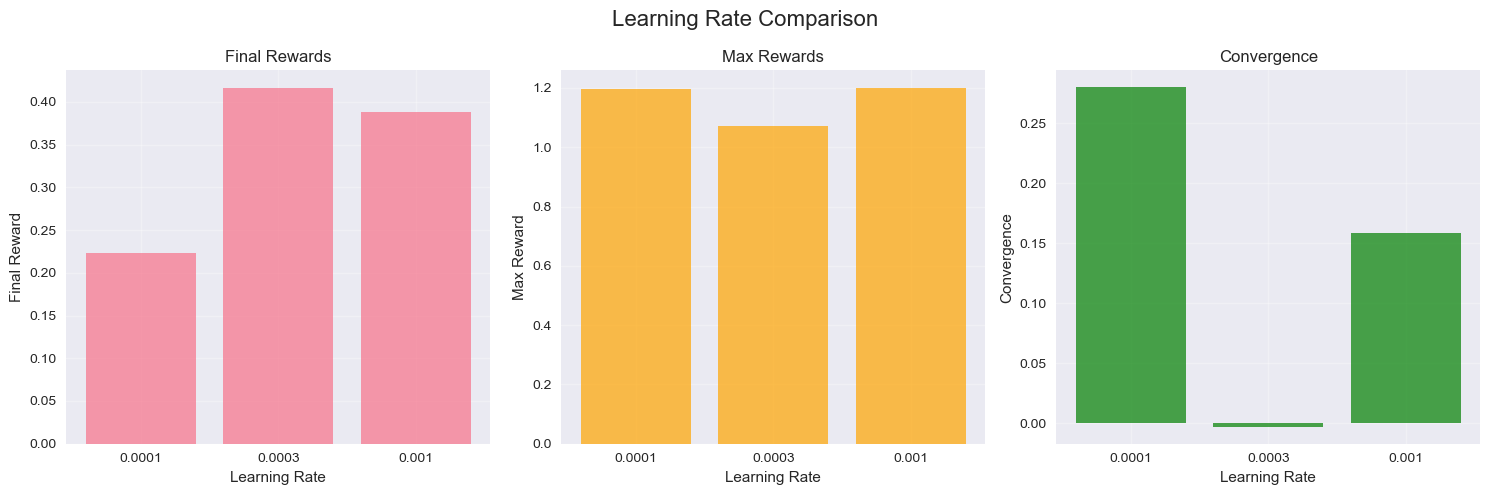


Best learning rate: 0.0003 (Final reward: 0.4160)


In [18]:
# Experiment with different hyperparameters
print("=== Hyperparameter Experiment ===")

# Test different learning rates for PPO
learning_rates = [1e-4, 3e-4, 1e-3]
lr_results = {}

for lr in learning_rates:
    print(f"\nTesting learning rate: {lr}")
    
    # Create agent with different learning rate
    agent = PPOAgent(
        state_dim=env_simple.observation_space.shape[0],
        action_dim=env_simple.action_space.shape[0],
        learning_rate=lr,
        gamma=0.99,
        clip_ratio=0.2,
        ppo_epochs=4,
        batch_size=64
    )
    
    # Train for shorter period
    metrics = train_agent(env_simple, agent, n_episodes=100, save_freq=50, verbose=False)
    
    # Store results
    lr_results[lr] = {
        'final_reward': np.mean(metrics['episode_rewards'][-20:]),
        'max_reward': np.max(metrics['episode_rewards']),
        'convergence': np.mean(metrics['episode_rewards'][-10:]) - np.mean(metrics['episode_rewards'][:10])
    }
    
    print(f"  Final reward: {lr_results[lr]['final_reward']:.4f}")
    print(f"  Max reward: {lr_results[lr]['max_reward']:.4f}")
    print(f"  Convergence: {lr_results[lr]['convergence']:.4f}")

# Plot learning rate comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Learning Rate Comparison', fontsize=16)

lrs = list(lr_results.keys())
final_rewards = [lr_results[lr]['final_reward'] for lr in lrs]
max_rewards = [lr_results[lr]['max_reward'] for lr in lrs]
convergences = [lr_results[lr]['convergence'] for lr in lrs]

axes[0].bar([str(lr) for lr in lrs], final_rewards, alpha=0.7)
axes[0].set_title('Final Rewards')
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Final Reward')
axes[0].grid(True, alpha=0.3)

axes[1].bar([str(lr) for lr in lrs], max_rewards, alpha=0.7, color='orange')
axes[1].set_title('Max Rewards')
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Max Reward')
axes[1].grid(True, alpha=0.3)

axes[2].bar([str(lr) for lr in lrs], convergences, alpha=0.7, color='green')
axes[2].set_title('Convergence')
axes[2].set_xlabel('Learning Rate')
axes[2].set_ylabel('Convergence')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best learning rate
best_lr = max(lr_results.keys(), key=lambda x: lr_results[x]['final_reward'])
print(f"\nBest learning rate: {best_lr} (Final reward: {lr_results[best_lr]['final_reward']:.4f})")


## 10. Save Results and Models


In [19]:
# Save training results
print("=== Saving Results ===")

# Create results directory
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)

# Save training metrics
with open(results_dir / 'ppo_training_metrics.json', 'w') as f:
    json.dump(ppo_metrics, f, indent=2)

with open(results_dir / 'dqn_training_metrics.json', 'w') as f:
    json.dump(dqn_metrics, f, indent=2)

# Save evaluation results
with open(results_dir / 'ppo_evaluation.json', 'w') as f:
    json.dump(ppo_eval, f, indent=2)

with open(results_dir / 'dqn_evaluation.json', 'w') as f:
    json.dump(dqn_eval, f, indent=2)

# Save hyperparameter results
with open(results_dir / 'hyperparameter_results.json', 'w') as f:
    json.dump(lr_results, f, indent=2)

print(f"Results saved to: {results_dir}")

# Save trained models
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

ppo_agent.save(str(models_dir / 'ppo_agent.pth'))
dqn_agent.save(str(models_dir / 'dqn_agent.pth'))

print(f"Models saved to: {models_dir}")
print("\nTraining and evaluation completed successfully!")


=== Saving Results ===
Results saved to: ..\results
Model saved to ..\models\ppo_agent.pth
Model saved to ..\models\dqn_agent.pth
Models saved to: ..\models

Training and evaluation completed successfully!


## 11. Summary and Next Steps


In [20]:
# Print summary
print("=== Training Summary ===")
print(f"Environment: {env_simple.__class__.__name__}")
print(f"State space: {env_simple.observation_space.shape}")
print(f"Action space: {env_simple.action_space.shape}")
print(f"Training episodes: {ppo_metrics['n_episodes']}")
print(f"\nBest performing agent: PPO")
print(f"PPO final reward: {np.mean(ppo_metrics['episode_rewards'][-50:]):.4f}")
print(f"DQN final reward: {np.mean(dqn_metrics['episode_rewards'][-50:]):.4f}")
print(f"\nBest learning rate: {best_lr}")
print(f"\nNext steps:")
print(f"1. Train on diversified environment with more stocks")
print(f"2. Implement more sophisticated reward functions")
print(f"3. Add ensemble methods")
print(f"4. Implement online learning and adaptation")
print(f"5. Deploy for live trading (with proper risk management)")


=== Training Summary ===
Environment: EnhancedPortfolioEnv
State space: (66,)
Action space: (6,)
Training episodes: 200

Best performing agent: PPO
PPO final reward: 0.2961
DQN final reward: 1.1701

Best learning rate: 0.0003

Next steps:
1. Train on diversified environment with more stocks
2. Implement more sophisticated reward functions
3. Add ensemble methods
4. Implement online learning and adaptation
5. Deploy for live trading (with proper risk management)
